# **Notebook 8.2: Bias-Variance Trade-Off**

This notebook investigates the bias-variance trade-off for the toy model used throughout chapter 8 and reproduces the bias/variance trade off curves seen in figure 8.9.

Work through the cells below, running each cell in turn. In various places you will see the words "TO DO". Follow the instructions at these places and make predictions about what is going to happen or write code to complete the functions.

Contact me at udlbookmail@gmail.com if you find any mistakes or have any suggestions.

In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import jax
from jax import Array
from jax.typing import ArrayLike


In [2]:
# The true function that we are trying to estimate, defined on [0,1]
def true_function(x:ArrayLike)->Array:
    y = jnp.exp(jnp.sin(x*(2*3.1413)))
    return y

In [3]:
# Generate some data points with or without noise
def generate_data(rng, n_data:int, sigma_y:float=0.3):
    # Generate x values quasi uniformly
    key_x,key_y = jax.random.split(rng,num=2)

    x = jax.random.uniform(key_x,shape=(n_data,)) * jnp.arange(n_data) / n_data

    # y value from running through functoin and adding noise
    y = jnp.ones(n_data)
    y = true_function(x) + sigma_y* jax.random.normal(key_y,shape=(n_data,))

    return x,y


In [4]:
# Draw the fitted function, together win uncertainty used to generate points
def plot_function(x_func, y_func, x_data=None,y_data=None, x_model = None, y_model =None, sigma_func = None, sigma_model=None):

    fig,ax = plt.subplots()
    ax.plot(x_func, y_func, 'k-')
    if sigma_func is not None:
      ax.fill_between(x_func, y_func-2*sigma_func, y_func+2*sigma_func, color='lightgray')

    if x_data is not None:
        ax.plot(x_data, y_data, 'o', color='#d18362')

    if x_model is not None:
        ax.plot(x_model, y_model, '-', color='#7fe7de')

    if sigma_model is not None:
      ax.fill_between(x_model, y_model-2*sigma_model, y_model+2*sigma_model, color='lightgray')

    ax.set_xlim(0,1)
    ax.set_xlabel('Input, $x$')
    ax.set_ylabel('Output, $y$')
    plt.show()

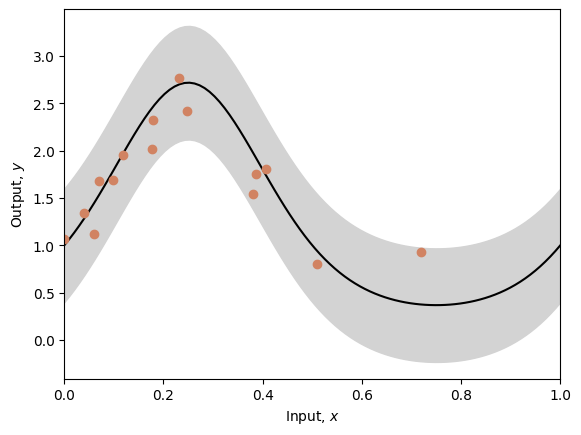

In [5]:
# Generate true function
x_func = jnp.linspace(0, 1.0, 100)
y_func = true_function(x_func);

# Generate some data points
rng = jax.random.PRNGKey(0)
sigma_func = 0.3
n_data = 15
x_data,y_data = generate_data(rng,n_data, sigma_func)

# Plot the functinon, data and uncertainty
plot_function(x_func, y_func, x_data, y_data, sigma_func=sigma_func)

In [14]:
# Define model -- beta is a scalar and omega has size n_hidden,1
def network(x:ArrayLike, beta, omega):
    # Retrieve number of hidden units
    n_hidden = omega.shape[0]

    def y_sum(n,x,n_hidden, omega):
      line_vals = x - n/n_hidden
      h = line_vals * (line_vals>0)

      if n==0:
        y = omega[n] * h
      else:
        y = y_sum(n-1,x,n_hidden,omega)+ omega[n] * h
      return y

    return y_sum(n_hidden,x,n_hidden,omega) + beta

In [10]:
# This fits the n_hidden+1 parameters (see fig 8.4a) in closed form.
# If you have studied linear algebra, then you will know it is a least
# squares solution of the form (A^TA)^-1A^Tb.  If you don't recognize that,
# then just take it on trust that this gives you the best possible solution.
def fit_model_closed_form(x:ArrayLike,y:ArrayLike,n_hidden:int):
  n_data = jnp.size(x)
  A = jnp.ones((n_data, n_hidden+1))
  for i in range(n_data):
      for j in range(1,n_hidden+1):
        A.at[i,j].set(x[i]-(j-1)/n_hidden)
        if A[i,j] < 0:
            A.at[i,j].set(0);

  ATA = jnp.matmul(jnp.transpose(A), A)
  ATAInv = jnp.linalg.inv(ATA)
  ATAInvAT = jnp.matmul(ATAInv, jnp.transpose(A))
  beta_omega = jnp.matmul(ATAInvAT,y)
  beta = beta_omega[0]
  omega = beta_omega[1:]

  return beta, omega


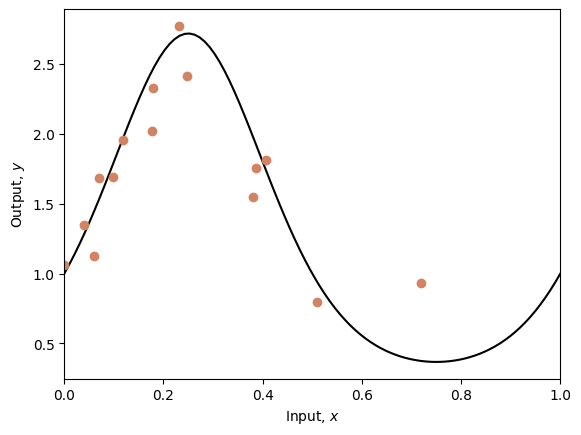

In [15]:
# Closed form solution
beta, omega = fit_model_closed_form(x_data,y_data,n_hidden=3)

# Get prediction for model across graph grange
x_model = jnp.linspace(0,1,100);
y_model = network(x_model, beta, omega)

# Draw the function and the model
plot_function(x_func, y_func, x_data,y_data, x_model, y_model)

In [21]:
# Run the model many times with different datasets and return the mean and variance
def get_model_mean_variance(key,n_data, n_datasets, n_hidden, sigma_func):

  # Create array that stores model results in rows
  x_model = jnp.linspace(0,1,100);
  y_model_all = jnp.zeros((n_datasets, x_model.shape[0]))


  for c_dataset in range(n_datasets):
    # TODO -- Generate n_data x,y, pairs with standard divation sigma_func
    # Replace this line
    x_data,y_data = generate_data(rng, n_data, sigma_y= sigma_func)

    # TODO -- Fit the model
    # Replace this line:
    beta, omega = fit_model_closed_form(x_data,y_data,n_hidden=3)

    # TODO -- Run the fitted model on x_model
    # Replace this line

    y_model = network(x_model, beta, omega)
    # Store the model results
    y_model_all.at[c_dataset,:].set(y_model)

  # Get mean and standard deviation of model
  mean_model = jnp.mean(y_model_all,axis=0)
  std_model = jnp.std(y_model_all,axis=0)

  # Return the mean and standard deviation of the fitted model
  return mean_model, std_model

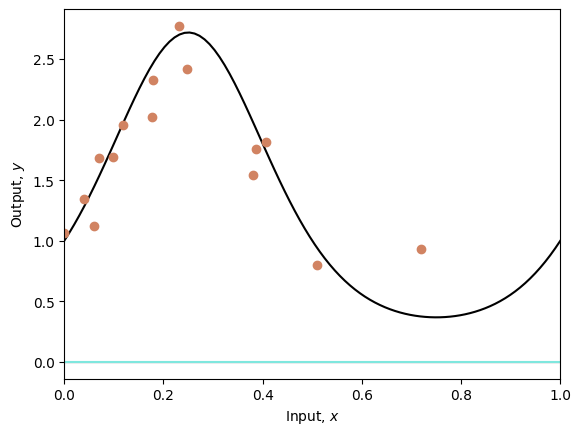

In [22]:
# Let's generate N random data sets, fit the model N times and look the mean and variance
n_datasets = 100
n_data = 15
sigma_func = 0.3
n_hidden = 5

# Get mean and variance of fitted model
rng = jax.random.PRNGKey(21)
mean_model, std_model = get_model_mean_variance(rng,n_data, n_datasets, n_hidden, sigma_func) ;

# Plot the results
plot_function(x_func, y_func, x_data,y_data, x_model, mean_model, sigma_model=std_model)

In [ ]:
# TODO -- Experiment with changing the number of data points and the number of hidden variables
# in the model.  Get a feeling for what happens in terms of the bias (squared deviation between cyan and black lines)
# and the variance (gray region) as we manipulate these quantities.

In [ ]:
# Plot the noise, bias and variance as a function of capacity
hidden_variables = [1,2,3,4,5,6,7,8,9,10,11,12]
bias = jnp.zeros((len(hidden_variables),1)) ;
variance = jnp.zeros((len(hidden_variables),1)) ;

n_datasets = 100
n_data = 15
sigma_func = 0.3
n_hidden = 5

# Set random seed so that get same result every time
rng = jax.random.PRNGKey(21)
for c_hidden in range(len(hidden_variables)):
  # Get mean and variance of fitted model
  mean_model, std_model = get_model_mean_variance(rng,n_data, n_datasets, hidden_variables[c_hidden], sigma_func) ;
  # TODO -- Estimate bias and variance
  # Replace these lines

  # Compute variance -- average of the model variance (average squared deviation of fitted models around mean fitted model)
  variance[c_hidden] = 0
  # Compute bias (average squared deviaton of mean fitted model around true function)
  bias[c_hidden] = 0

# Plot the results
fig,ax = plt.subplots()
ax.plot(hidden_variables, variance, 'k-')
ax.plot(hidden_variables, bias, 'r-')
ax.plot(hidden_variables, variance+bias, 'g-')
ax.set_xlim(0,12)
ax.set_ylim(0,0.5)
ax.set_xlabel("Model capacity")
ax.set_ylabel("Variance")
ax.legend(['Variance', 'Bias', 'Bias + Variance'])
plt.show()
